In [2]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -qq ./drive/MyDrive/ButterflyIdentification.zip

In [5]:
!ls

drive  sample_data  test  Testing_set.csv  train  Training_set.csv


### 이미지 불러오기

In [6]:
train = "./train"
test = "./test"
labels = pd.read_csv('./Training_set.csv')
labels_test=pd.read_csv('./Testing_set.csv')

In [7]:
print(labels.shape)

(6499, 2)


*   train -> 학습시킬 이미지
*   test -> 테스트 돌릴 이미지
*   labels -> 학습이미지 레이블
*   labels_test-> 테스트 이미지 레이블

### CNN알고리즘 수행

In [14]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

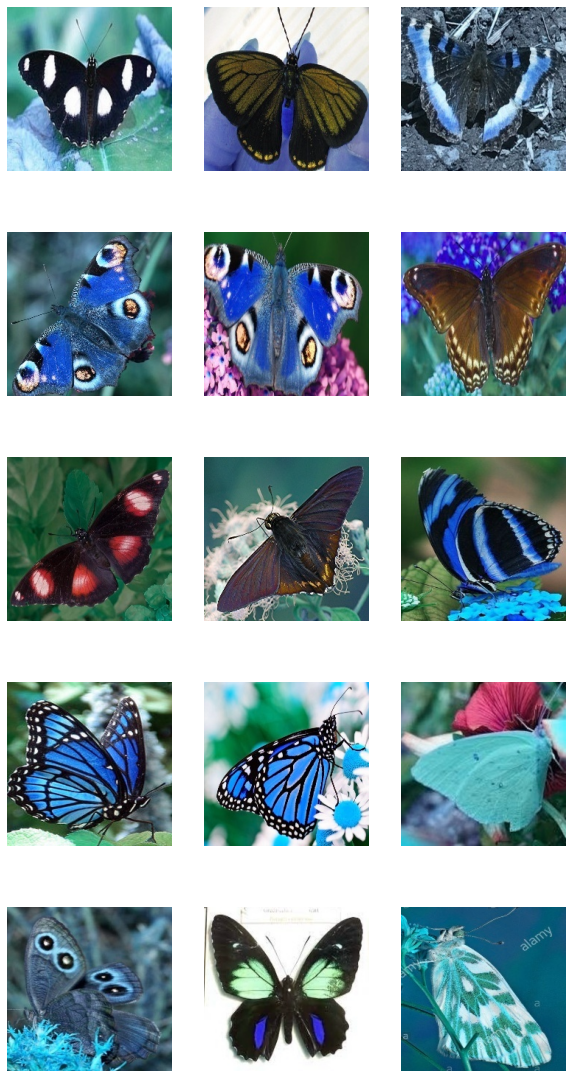

In [34]:
# 무작위로 train폴더 내의 샘플 이미지 표시 (15개)
example_images = random.sample(os.listdir(train), 15)

fig = plt.figure(figsize=(10,20))
for i, im in enumerate(example_images):
    plt.subplot(5, 3, i+1)
    im = cv2.imread(os.path.join(train, im))
    plt.imshow(im)
    plt.axis('off')
plt.show()

In [16]:
# train을 학습용과 실전용으로 분리 (8:2)
validation_split = 0.8
idxs = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[idxs]
val_labels = labels[~idxs]
print(len(train_labels), len(val_labels))

5200 1299


In [26]:
batch_size = 64
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=5,
    shear_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_labels,
    directory=train,x_col='filename',
    y_col='label',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)
val_generator = train_datagen.flow_from_dataframe(
    val_labels,
    directory=train,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.


In [18]:
# 텐서플로우에서 제공하는 Inception V3모델을 통해 분류
base_model = tf.keras.applications.InceptionV3(input_shape=(150,150,3),include_top=False,weights="imagenet")

In [19]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(75, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 75)                9675      
                                                                 
Total params: 24,188,395
Trainable params: 2,385,803
Non

In [21]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [27]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),  
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

In [28]:
lrd = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    factor = 0.50,
    min_lr = 1e-6
)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(
    verbose=1,
    patience=3
)

In [29]:
model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [25]:
# 학습 시작
%time
history=model.fit(train_generator,validation_data=val_generator,epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
Epoch 1/20
82/82 [==============================] - 309s 4s/step - loss: 4.3402 - accuracy: 0.1162 - precision: 0.3425 - recall: 0.0192 - auc: 0.7099 - f1_score: 0.0355 - val_loss: 3.1636 - val_accuracy: 0.2425 - val_precision: 0.7207 - val_recall: 0.0616 - val_auc: 0.8449 - val_f1_score: 0.1121 - lr: 0.0010
Epoch 2/20
82/82 [==============================] - 303s 4s/step - loss: 2.5758 - accuracy: 0.3285 - precision: 0.6437 - recall: 0.1512 - auc: 0.9104 - f1_score: 0.2410 - val_loss: 2.5768 - val_accuracy: 0.3472 - val_precision: 0.6450 - val_recall: 0.1832 - val_auc: 0.9038 - val_f1_score: 0.2798 - lr: 0.0010
Epoch 3/20
82/82 [==============================] - 305s 4s/step - loss: 2.0155 - accuracy: 0.4467 - precision: 0.6674 - recall: 0.2871 - auc: 0.9434 - f1_score: 0.3980 - val_loss: 1.8447 - val_accuracy: 0.4881 - val_precision: 0.7228 - val_recall: 0.3072 - val_auc: 0.9525 - val_f1_score: 0.4322 - lr: 0.0010
Epoch 

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 진짜 실전용 데이터 투입
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_dataframe(
    labels_test,
    directory=test,
    x_col='filename',
    class_mode=None,
    batch_size=batch_size,
    target_size=(150,150)
)

In [ ]:
y_pred = pd.DataFrame((model.predict(test_generator) > 0.5).astype("int32"))
y_pred['filename']=labels_test['filename']
y_pred